In [1]:
import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import myServices as ms
import models as md
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score, f1_score
import joblib

In [2]:
# to compute ececution time do:
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

## Importing and manipulating datasets

In [ ]:
sklearn.metrics.get_scorer_names()

In [ ]:
### Cleaning basin1DataSet 
DS = pd.read_csv('datasetBasin1.csv', index_col = None)
print(DS.info())
DS = DS.dropna()
print(DS.info())
DS.to_csv('datasetBasin1_NoDataFree.csv', index = None)
DS.describe()

## balanced sampling

In [ ]:
## Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

X,Y = ms.importDataSet('datasetBasin1_NoDataFree.csv', 'percentage')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in sss.split(X, Y):
    print("TRAIN:", train_index.size, "TEST:", test_index)
    X_train = X.iloc[train_index]
    y_train = Y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = Y.iloc[test_index]

In [ ]:
basin1TestBalanced = X_test
basin1TestBalanced['percentage'] = y_test
print(X_test.head())
basin1TestBalanced.to_csv('basin1TestForBanlanced.csv', index=None)

In [ ]:
print( y_train.value_counts())
print(y_test.value_counts())

In [ ]:
## This proportions are the reason why a sample_weight of 0.01 for the majority class give best results for regression

totalTrain = sum([1941324, 35056, 7250])
totalValidation = sum([485332,8764, 1812])
print("Balance summary of train dataset")
print(f"Class 1% : {1941324/totalTrain}, Class 1%: {7250/totalTrain}, Class 5%: {35056/totalTrain}")
print(f"Class 1% : {485332/totalValidation}, Class 1%: {1812/totalValidation}, Class 5%: {8764/totalValidation}")

In [ ]:
#### Undersampling  NOTE: For details read about <sampling_strategy>

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

sm = RandomUnderSampler(random_state=50, sampling_strategy='auto')
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

In [ ]:

X_train['percentage'] = y_train
print(X_res.head())
X_train.drop(['x_coord','y_coord'], axis=1, inplace = True)

X_train.to_csv('basin1TrainUnbalanced.csv', index=None)

In [ ]:
X_res['percentage'] = y_res
print(X_res.head())
X_res.drop(['x_coord','y_coord'], axis=1, inplace = True)

X_res.to_csv('basin1TrainingBanlanced.csv', index=None)

X,Y = ms.importDataSet('basin1TrainingBanlanced.csv', 'percentage')

In [ ]:
print(X_res.head())

In [ ]:
X,Y = ms.importDataSet('basin1TestForBanlanced.csv', 'percentage')
print('Resampled dataset shape %s' % Counter(Y))

In [ ]:
model = ms.loadModel('./outputs/2022-08-05/00-35-58/2208050035.pkl')
dataSetToSave = ms.makePredictionToImportAsSHP(csvName, model, X, Y, 'percentage')
print(dataSetToSave.head())

In [ ]:
dataSetToSave.to_csv('basin1ClassifierPrediction1_balanced.csv', index = None)

In [ ]:
print(model)

In [ ]:
x_train['percentage'] = y_train
print(x_train.head())

In [ ]:
x_train.to_csv('basin1Train.csv', index = None)

In [ ]:
RFClassifier = md.implementRandomForestCalssifier()

In [ ]:
model = md.loadModel('./bestModels/21-46-40 Classifier/2207232146.pkl')

In [ ]:
print(model)

# Data description and visualization

In [ ]:
### FAcc vs Labels
targets = DS['percentage']
FAcc = original['FAcc']
FAcc_norm = DS['FAcc_norm']
fig, axs = plt.subplots(1, 2, figsize=(13,4), sharey=True)
fig.text(-0.02, 0.5, 'labels', va='center', rotation='vertical')
fig.text(0.5, 1, 'Flow accumulation vs labels distribution', ha ='center')
axs[0].scatter(FAcc,targets)
# axs[0].set_title("Facc")
axs[0].set(xlabel='a) Flow Accumulation')
axs[1].scatter(FAcc_norm,targets)
# axs[1].set_title("FAcc_norm")
axs[1].set(xlabel='b) Flow Accumulation estandardized')
plt.rcParams['font.size'] = '20'
fig.tight_layout()


In [ ]:
##3 Al features vs labels
# 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',
targets = DS['percentage']
# targets = np.where( targets == 5, 2,targets)

E = DS['elevation'] 
slope = DS['slope']
FAcc = DS['FAcc_norm']
S = DS['disToRiv']
TWI = DS['TWI']
TPI = DS['TPI']

fig, axs = plt.subplots(3, 2, figsize=(13, 8), sharey=True)
fig.supylabel('Labels')
plt.rcParams['font.size'] = '15'
plt.yticks([0,1,5])
axs[0, 0].scatter(E,targets)
axs[0, 0].set_title("Elevation")
axs[1, 0].scatter(slope,targets)
axs[1, 0].set_title("Slope")
axs[2, 0].scatter(FAcc,targets)
axs[2, 0].set_title("Flow accumulation")
axs[0, 1].scatter(S,targets)
axs[0, 1].set_title("Distance to river")
axs[1, 1].scatter(TWI,targets)
axs[1, 1].set_title("TWI")
axs[2, 1].scatter(TPI,targets)
axs[2, 1].set_title('TPI')
fig.tight_layout()


In [ ]:
print(DS.head())
#  Return a dataset with the rows corresponding to the index where condition in DS.columName is valid. 
dsArray = DS[DS.percentage != 0] print(dsArray.head())
print(dsArray.head()) 

In [ ]:
sns.set(font_scale=1.5)
sns.pairplot(DS, hue = 'percentage', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.8, 's': 100},
             height = 4, corner=True, palette = "Set2")# vars = ['life_exp', 'log_pop', 'log_gdp_per_cap'],

# sns.pairplot(DS, hue="percentage")

In [ ]:
####. Covariance Matrix
matrix = DS.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(criterion='entropy', random_state = 50)
x_train,y_train = ms.importDataSet('basin1Train.csv', 'percentage')
classifier = OneVsRestClassifier(estimator).fit(x_train,y_train)


In [10]:
classifier = ms.loadModel('./outputs/2022-08-05/11-01-57/2208051101.pkl')
x_test,y_test = ms.importDataSet('basin1Test.csv', 'percentage')

x_test = ms.removeCoordinatesFromDataSet(x_test)

# y_prob = classifier.predict_proba(x_test)
#print(np.unique(y_prob))

UNIQUE CLASSES:  [0 5 1]
Test Set balance:
values, counts , percent
[[     0 485332      0]
 [     1   1812      0]
 [     5   8764      0]]
Prediction balance:
values, counts , percent
[[     0 488893      0]
 [     1    567      0]
 [     5   6448      0]]
actual class: 0 vs rest [5, 1]
Class 0 balance vs rest
values, counts , percent
[[     0  10576      0]
 [     1 485332      0]]
actual class: 5 vs rest [0, 1]
Class 5 balance vs rest
values, counts , percent
[[     0 487144      0]
 [     1   8764      0]]
actual class: 1 vs rest [0, 5]
Class 1 balance vs rest
values, counts , percent
[[     0 494096      0]
 [     1   1812      0]]


{0: 0.7819874515800048, 5: 0.8032277779296414, 1: 0.6043903275215913}

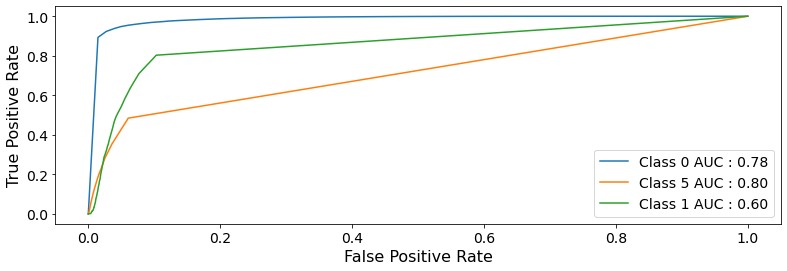

<Figure size 432x288 with 0 Axes>

In [11]:
md.plot_ROC_AUC_OneVsRest(classifier, x_test, y_test)

In [14]:
_,y_test = ms.importDataSet('./bestModels/Classifier/10-18-08/2208051018prediction_basin1Test.csv', 'prediction')
unique, count = np.unique(y_test, return_counts=True)
total = count.sum()
print(total)
percent = np.round(np.zeros_like(unique).astype('float16'),3)
print('values, counts , percent')
for i in range(len(unique)):    
   percent[i] = (count[i]/total)*100
   print(unique[i],"\t", count[i], percent[i])


495908
values, counts , percent
0 	 422058 85.1
1 	 44718 9.016
5 	 29132 5.875
